In [179]:
import pymc as pm
import netCDF4 as nc
import numpy as np
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt


events = ["GW150914","GW170104","GW170823","GW190519_153544",
		"GW190521","GW190521_074359","GW190706_222641",
		"GW190828_063405","GW200224_222234","GW200311_115853"]

ds = {}
points = {}

for event in events:
	fn = f"./ChargedResults/{event}/{event}-charged-posteriors.nc"
	a = nc.Dataset(fn)
	ds[event] = a
	points[event] = np.array([np.array(x) for x in zip(a['posterior']['chi'][:].flatten(),a['posterior']['Q_charge'][:].flatten())])

events_that_look_alright = ['GW150914','GW190519_153544',
                            'GW190521','GW190521_074359',
                            'GW190706_222641','GW200224_222234']

## Changing Variables:
def chiq_to_rtheta(arr):
    A = np.sqrt(arr[:,0]**2 + arr[:,1]**2)
    theta = np.arctan(arr[:,1]/arr[:,0])
    return np.array([A,theta]).transpose()

def rtheta_to_chiq(arr):
    chi = arr[:,0]*np.cos(arr[:,1])
    Q = arr[:,0]*np.sin(arr[:,1])
    return np.array([chi,Q]).transpose()

points_good = {k:chiq_to_rtheta(v) for k,v in points.items() if k in events_that_look_alright}

We have all the samples from good events in points_good. 

Lets look at GW150914 in an $r$ vs $\theta$ hexbin plot

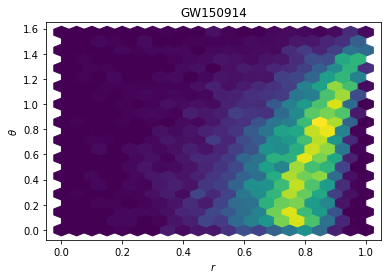

In [317]:
def plot_rtheta(points, name='GW150914'):
    plt.hexbin(points[:,0],points[:,1],gridsize=20, extent=(0,1,0,np.pi/2))
    plt.xlabel('$r$')
    plt.ylabel('$\\theta$')
    plt.title(name)
    plt.show()
    
def axplot_rtheta(ax,points, gridsize=20, **kwargs):
    ax.hexbin(points[:,0],points[:,1],gridsize=gridsize, extent=(0,1,0,np.pi/2), **kwargs)
    return ax

plot_rtheta(points_good['GW150914'], name='GW150914')

##### Reweighting
Now we try to take a random subset, but give more weightage to higher radius points.

In [246]:
samps = points_good['GW150914']

weight_function = lambda rtheta: 1/rtheta[0]
weights = np.apply_along_axis(weight_function, 1, samps)
weights = weights/np.sum(weights)

chosen_indices = np.random.choice(len(samps),p=weights,size=8000)
new_samples = samps[chosen_indices]

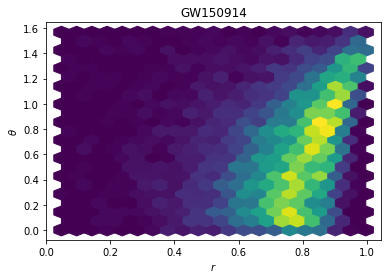

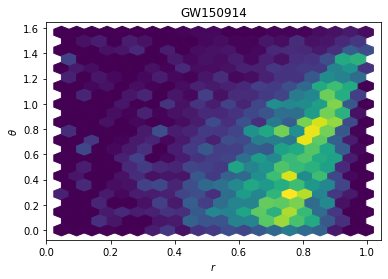

In [247]:
plot_rtheta(samps, name='old samples')
plot_rtheta(new_samples, name='1/r weighted')

How do we validate that it is actually from the correct distribution?? No Idea. 

Create the KDE expression, then add a 1/r jacobian. 

### But first, the KDE estimate
I thought: Let's create a KDE estimate of the posterior from the samples, then sample from the likelihood by subtracting from the `logp`.

It seems that the subset_size of 200 is pretty decent. 

In [300]:
# Choose a subset of the samples
ndim = 2
subset_size = 200
samp_inds = np.random.choice(samps.shape[0],subset_size)
chosen_samps = samps[samp_inds]

def get_bws(samps):
    x_samples = samps.reshape((1,samps.shape[0],samps.shape[1]))
    nobs, nsamp, ndim = x_samples.shape

    means = np.mean(x_samples, axis=1)
    deviations = x_samples - means[:,np.newaxis,:]
    dev_matrix = deviations[:,:,:,np.newaxis]*deviations[:,:,np.newaxis,:]
    covariances = np.mean(dev_matrix, axis=1)
    bws = covariances / nsamp**(2/(4+ndim)) # Scott's rule for the KDE bandwidth
    return bws

with pm.Model() as model:
    
    # Get scott's rule bandwidth covariance
    bws = get_bws(chosen_samps).reshape((2,2))
    dists = [pm.MvNormal.dist(mu=chosen_samps[i,:], cov=bws) for i in range(chosen_samps.shape[0])]
    
    # Create mixture and sample from the mixture
    weights = np.ones(len(dists))/len(dists)
    mix = pm.Mixture('mix', w=weights, comp_dists=dists)
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix]
INFO:pymc:NUTS: [mix]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 149 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 149 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Below I've plotted KDE estimate from the event. It doensn't look that representative:

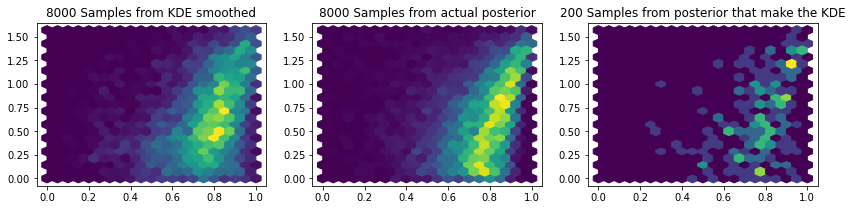

In [319]:
# KDE smoothing of `subset_size` random points from the GW150914 posterior
trace_mixed = trace.posterior['mix'].values
points2 = trace_mixed.reshape((trace_mixed.shape[0]*trace_mixed.shape[1], trace_mixed.shape[2]))

fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(14,3))

ax1 = axes[0]
ax1 = axplot_rtheta(ax1, points2)
ax1.set_title(f"{points2.shape[0]} Samples from KDE smoothed")

ax2 = axes[1]
ax2 = axplot_rtheta(ax2, samps)
ax2.set_title(f"{samps.shape[0]} Samples from actual posterior")

ax3 = axes[2]
ax3 = axplot_rtheta(ax3, samps[samp_inds])
ax3.set_title(f"{subset_size} Samples from posterior that make the KDE")


plt.show()

#### Creating a Gaussian Mixture Model as the right form of a "KDE estimate"

In [352]:
from sklearn.mixture import GaussianMixture
n_gauss = 20
gm = GaussianMixture(n_components=n_gauss).fit(samps)
gm_spherical = GaussianMixture(n_components=n_gauss*2).fit(samps)

#### Mixture Model does much much better with less Gaussians

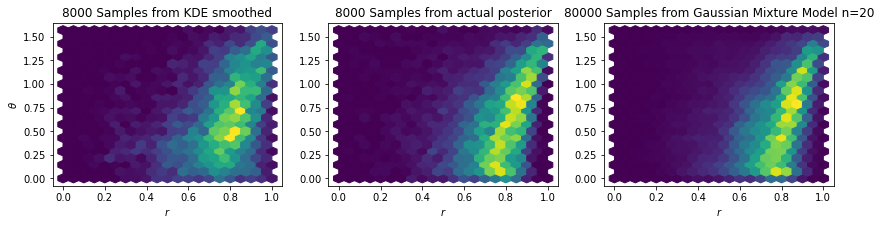

In [440]:
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(14,3))

ax1 = axes[0]
ax1 = axplot_rtheta(ax1, points2)
ax1.set_title(f"{points2.shape[0]} Samples from KDE smoothed")
ax1.set_ylabel(r"$\theta$")
ax1.set_xlabel(r"$r$")

ax2 = axes[1]
ax2 = axplot_rtheta(ax2, samps)
ax2.set_title(f"{samps.shape[0]} Samples from actual posterior")
ax2.set_xlabel(r"$r$")


ax3 = axes[2]
ax3 = axplot_rtheta(ax3, gm.sample(80000)[0])
ax3.set_xlabel(r"$r$")
ax3.set_title(f"{80000} Samples from Gaussian Mixture Model n={n_gauss}")

plt.show()

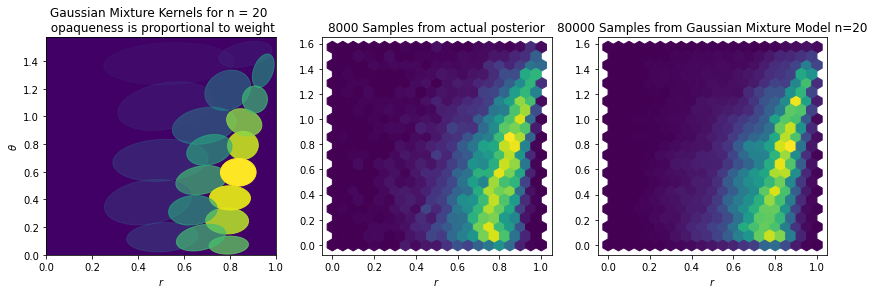

In [533]:
fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(14,4))

ax1 = axes[0]

from matplotlib import patches

def gaussian_ellipse(mean, cov, alpha=0.5, color='yellow'):
    x,y = mean
    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    el = patches.Ellipse(mean, v[0], v[1], 180.0 + angle, alpha=alpha, color=plt.get_cmap('viridis')(alpha))
    return el
    
def ax_plot_GMM(ax,gm):
    ax.set_xlim((0,1))
    ax.set_ylim((0,np.pi/2))
    ax.set_xlabel(r"$r$")
    ax.set_ylabel(r"$\theta$")
    ax.set_facecolor([0.25,0.0,0.4])
    for i in range(n_gauss):
        el = gaussian_ellipse(gm.means_[i], gm.covariances_[i], 
                              alpha=gm.weights_[i]/gm.weights_.max())
        ax.add_patch(el)
    return ax
    
    
ax1 = ax_plot_GMM(ax1, gm)
ax1.set_title(f"Gaussian Mixture Kernels for n = {n_gauss} \n opaqueness is proportional to weight")

ax2 = axes[1]
ax2 = axplot_rtheta(ax2, samps)
ax2.set_title(f"{samps.shape[0]} Samples from actual posterior")
ax2.set_xlabel(r"$r$")


ax3 = axes[2]
ax3 = axplot_rtheta(ax3, gm.sample(80000)[0])
ax3.set_xlabel(r"$r$")
ax3.set_title(f"{80000} Samples from Gaussian Mixture Model n={n_gauss}")


plt.show()

Now lets try and use the new mixture model to generate the logp of a new system which simply has an extra factor of 1/r. i.e. 
$$
\log{p}= \log{p} - \log{r}
$$

Next I need to figure out how to add the 1/r factor in the pymc sampling so that we can sample from the likelihood

In [583]:
oversampling = 100

weight_function = lambda rtheta: 1/rtheta[0]
weights = np.apply_along_axis(weight_function, 1, samps)
weights = weights/np.sum(weights)
equal_weights = np.ones(samps.shape[0])/samps.shape[0]

chosen_indices = np.random.choice(len(samps),p=weights,size=100*samps.shape[0])
new_samples = samps[chosen_indices]

#chosen_old_indices = np.random.choice(len(samps),p=equal_weights,size=100*samps.shape[0])
#old_samples = samps[chosen_old_indices]
old_samples = np.tile(samps.T, oversampling).T

In [589]:
gm = GaussianMixture(n_components=n_gauss, n_init=10).fit(samps)
old_gm = GaussianMixture(n_components=n_gauss, n_init=10).fit(old_samples)
new_gm = GaussianMixture(n_components=n_gauss, n_init=10).fit(new_samples)

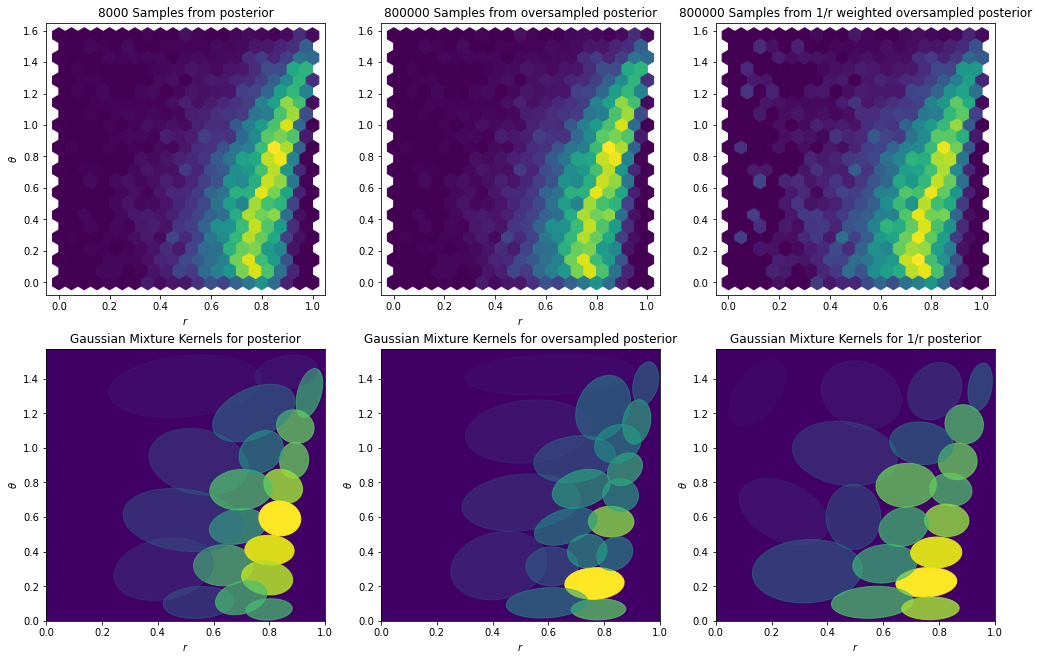

In [590]:
fig, axes = plt.subplots(ncols=3,nrows=2, figsize=(17,11))

ax00 = axes[0,0]
ax00 = axplot_rtheta(ax00, samps)
ax00.set_title(f"{samps.shape[0]} Samples from posterior")
ax00.set_ylabel(r"$\theta$")
ax00.set_xlabel(r"$r$")

ax01 = axes[0,1]
ax01 = axplot_rtheta(ax01, old_samples)
ax01.set_title(f"{old_samples.shape[0]} Samples from oversampled posterior")
ax01.set_xlabel(r"$r$")

ax02 = axes[0,2]
ax02 = axplot_rtheta(ax02, new_samples)
ax02.set_title(f"{new_samples.shape[0]} Samples from 1/r weighted oversampled posterior")

ax3 = axes[1,0]
ax3 = ax_plot_GMM(ax3, gm)
ax3.set_title(f"Gaussian Mixture Kernels for posterior")

ax4 = axes[1,1]
ax4 = ax_plot_GMM(ax4, old_gm)
ax4.set_title(f"Gaussian Mixture Kernels for oversampled posterior")

ax5 = axes[1,2]
ax5 = ax_plot_GMM(ax5, new_gm)
ax5.set_title(f"Gaussian Mixture Kernels for 1/r posterior")

plt.show()

In [593]:
import aesara
import aesara.tensor as at

k = at.iscalar("k")
A = at.vector("A")

# Symbolic description of the result
result, updates = aesara.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=at.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
#final_result = result[-1]

# compiled function that returns A**k
power = aesara.function(inputs=[A,k], outputs=result, updates=updates)

print(power(range(10),2))
print(power(range(10),4))

TypeError: map() got an unexpected keyword argument 'outputs_info'

In [603]:
M = at.matrix('M')
a = at.dscalar('a')
b = at.dscalar('B')
result, updates = aesara.reduce(fn=lambda x,a,b: x*a,
                            sequences=[M],
                            outputs_info={'initial': b},
                            non_sequences=[a])

ValueError: When compiling the inner function of scan (the function called by scan in each of its iterations) the following error has been encountered: The initial state (`outputs_info` in scan nomenclature) of variable IncSubtensor{Set;:int64:}.0 (argument number 1) has 1 dimension(s), while the corresponding variable in the result of the inner function of scan (`fn`) has 1 dimension(s) (it should be one less than the initial state). For example, if the inner function of scan returns a vector of size d and scan uses the values of the previous time-step, then the initial state in scan should be a matrix of shape (1, d). The first dimension of this matrix corresponds to the number of previous time-steps that scan uses in each of its iterations. In order to solve this issue if the two varialbe currently have the same dimensionality, you can increase the dimensionality of the variable in the initial state of scan by using dimshuffle or shape_padleft. 

In [599]:
f = aesara.function(inputs=[M, a], outputs=result)

In [600]:
f([[1,2],[32,4]],0.4)

array([[ 0.4,  0.8],
       [12.8,  1.6]])